# Feature Matching

This is the point in the course where we can start to do cool stuff with open cv and what we have learned before.

We have already seen template matching which finds a smaller image in the large image, but it requires a exact copy of the image. So, often it isn't useful in real life situations.

* Feature matching extracts defining key features from an input image (using ideas from corner, edge and contour detection).
* Then using a distance calculation,find all the matches in a secondary image.
* This means we are no longer required to have a exact copy of the target image.

**We will be using 3 methods:**
1. Brute force matching with ORB descriptors.
2. Brute-force matching with SIFT descriptors and Ratio test.
3. FLANN based matcher.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

In [4]:
reeses = cv2.imread('../DATA/reeses_puffs.png',0)     

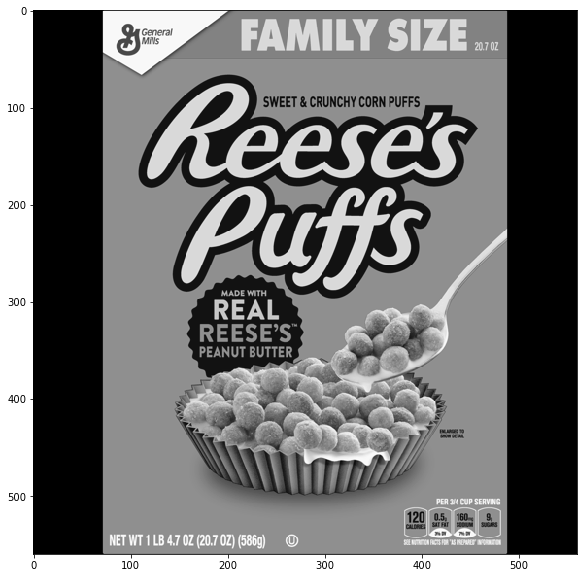

In [5]:
display(reeses)

This is just a front cover photo of reese puff cereal box and not the actual box and it also has family size at the top

In [6]:
cereals = cv2.imread('../DATA/many_cereals.jpg',0) 

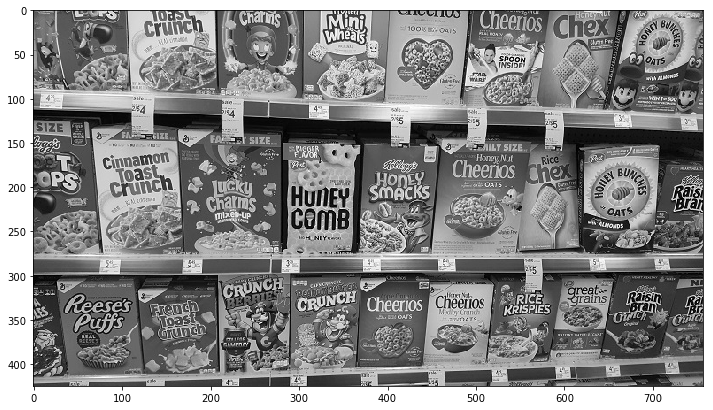

In [7]:
display(cereals)

This is actually a cereal aisle where the left bottom corner is reese puffs and it does not have family size at the top like the image above. The photos of all the cereals are also not centered towards the camera like the above image.

There are some boxes with 'family size' written on top so we might get some matches for them.

***
# Method 1

In [8]:
# a object for detector

orb = cv2.ORB_create()

In [9]:
# the second parameter is a possible mask
# this returns two things the keypoints and the descriptors for them

# the target image
kp1, des1 = orb.detectAndCompute(reeses, None)


# for the main image i.e. cereals
kp2, des2 = orb.detectAndCompute(cereals, None)

Now that we have the descriptors we can match them

In [10]:
# just some default parameters
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

In [11]:
matches = bf.match(des1, des2)

In [12]:
matches[:5]

[<DMatch 000001ED067E0310>,
 <DMatch 000001ED069A7D90>,
 <DMatch 000001ED069A7E50>,
 <DMatch 000001ED069A7EB0>,
 <DMatch 000001ED069A7AB0>]

In [13]:
len(matches)

263

These are kind of encoded objects and we have detected these many matches found with the target image in the base image.

With these matches we do some things like

In [14]:
single_match = matches[0]

In [15]:
single_match

<DMatch 000001ED067E0310>

In [16]:
single_match.distance

78.0

This is the distance and the lower it is the better the feature match with our image.

Now we can sort the above list of matches based on distance with a for loop but a easier way to do that is using lambda expression.

In [17]:
matches = sorted(matches, key=lambda x:x.distance)

In [18]:
# the first 25 matches
reeses_matches = cv2.drawMatches(reeses, kp1, cereals, kp2, matches[:25], None, flags = 2)

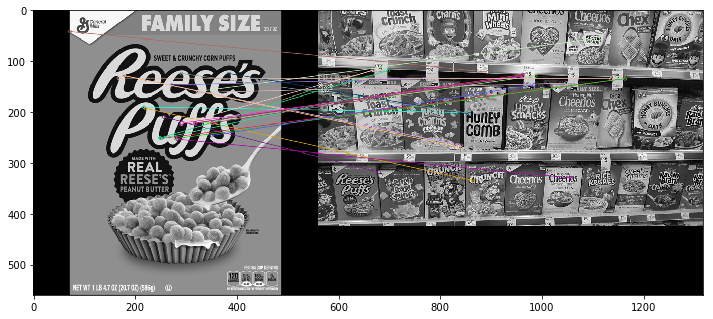

In [19]:
display(reeses_matches)

This method

This one doesn't perform that well. We did not get a match with the actual image of the reeses puffs box in the base image but 
* Our reeses box in the base image is tilted and a little blurred compared to the above boxes
* Our reeses box in the base image does not have family size but target image does.


**For these we are gonna need some more sophisticated methods than brute force to succesfully detect the correct box**

# Method 2 : SIFT

This works very well when we are dealing with image sizes that are at a different scale. And in our own image the target image is pretty large while the image of reeses puffs in the base image is not that big.

In [20]:
sift = cv2.xfeatures2d.SIFT_create()

In [21]:
kp1, des1 = sift.detectAndCompute(reeses, None)

kp2, des2 = sift.detectAndCompute(cereals, None)

In [27]:
bf = cv2.BFMatcher()

In [28]:
des1

array([[ 15.,   0.,   0., ...,  11.,   1.,   0.],
       [ 21.,   0.,   0., ...,   0.,  10.,  13.],
       [150.,   1.,   0., ...,   0.,   0.,   0.],
       ...,
       [ 61.,   6.,   0., ...,   0.,   0.,   0.],
       [ 27.,   0.,   0., ...,   0.,   0.,   0.],
       [ 48.,   0.,   0., ...,   0.,   1.,   0.]], dtype=float32)

In [29]:
matches = bf.knnMatch(des1, des2, k=2)

We are using knn mathes to find the top two matches. We are basically finding k-best matches for each descriptors.

In [31]:
matches[:5]

[[<DMatch 000001ED06D171B0>, <DMatch 000001ED06D17B10>],
 [<DMatch 000001ED06D17090>, <DMatch 000001ED06D17F90>],
 [<DMatch 000001ED06D17710>, <DMatch 000001ED065410B0>],
 [<DMatch 000001ED06541E70>, <DMatch 000001ED06541EB0>],
 [<DMatch 000001ED06541ED0>, <DMatch 000001ED06541070>]]

Notice that the matches are in pairs of two as we gave k=2. 

In [32]:
single_match = matches[0]

In [33]:
single_match

[<DMatch 000001ED06D171B0>, <DMatch 000001ED06D17B10>]

First best match is a better match than the second best match

If first match is prettly close in terms of distance with second match, then overall it is a good feature to match on.

And

If first match is pretty far in terms of distance with second match, then the pair overall is probably not a good feature to match on.

We are going to use ratio to find the best distance based match pairs to select as features to match on.

**Basically if the two matches are close in distance then the pair is a good feature**

In [34]:
good = []

# Ratio Test
# MATCH 1 < 75% MATCH 2
# LESS DISTANCE == BETTER MATCH

for match1, match2 in matches:
    # if distance for match1 is less than 75% of the distance of match 2
    # then the descriptor i.e. the whole row was a good match, lets keep it.
    
    # We are basically checking the distance between the pair of matches and if it is greater than
    # 75% of the first one, then it is not a good match
    if match1.distance < 0.75*match2.distance:
        good.append([match1])

In [35]:
good[:5]

[[<DMatch 000001ED06541AB0>],
 [<DMatch 000001ED09387CB0>],
 [<DMatch 000001ED09387E70>],
 [<DMatch 000001ED08EFB4D0>],
 [<DMatch 000001ED08EFB990>]]

In [36]:
len(good)

78

In [37]:
len(matches)

1500

So, we had a lot of poor matches and they were all thrown away

In [38]:
sift_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags = 2)

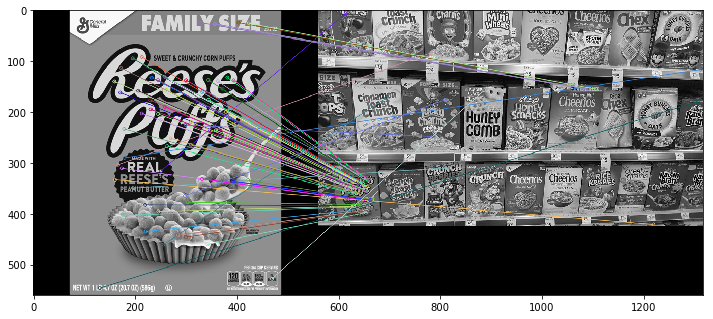

In [39]:
display(sift_matches)

This performed much much better that brute force match and was able to find the box of reeses puffs.

* The reese puffs were matched with the actual resse puff box
* family size was matched with the family size on other boxes 


# Method 3 : Sift with FLANN

FLANN : fast library for approximate near neighbours.

In [40]:
sift = cv2.xfeatures2d.SIFT_create()

In [41]:
kp1, des1 = sift.detectAndCompute(reeses, None)

kp2, des2 = sift.detectAndCompute(cereals, None)

Now it is gonna be a little different 

In [43]:
# FLANN
# This is gonna be much faster than brute force methods but it does not find the best possible matches. Instead it is
# gonna the general good matches

# Now we can play around with flann parameter to increase the accuracy but that comes at the cost of time. It will slow down

# these are the default parameters and we can play around with them like increase the number of trees and all but it will
# it slower
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)

search_params = dict(checks=50)

In [44]:
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [45]:
matches = flann.knnMatch(des1, des2, k=2)

In [46]:
matches[:5]

[[<DMatch 000001ED06541050>, <DMatch 000001ED08FA53D0>],
 [<DMatch 000001ED08FA56F0>, <DMatch 000001ED08FA5530>],
 [<DMatch 000001ED08FA5230>, <DMatch 000001ED08FA52B0>],
 [<DMatch 000001ED08FA5550>, <DMatch 000001ED08FA51D0>],
 [<DMatch 000001ED08FA5350>, <DMatch 000001ED08FA5A50>]]

In [47]:
len(matches)

1500

In [48]:
# ratio test

good = []

for match1, match2 in matches:
    if match1.distance < 0.7* match2.distance:
        good.append([match1])

In [50]:
flann_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags = 0)

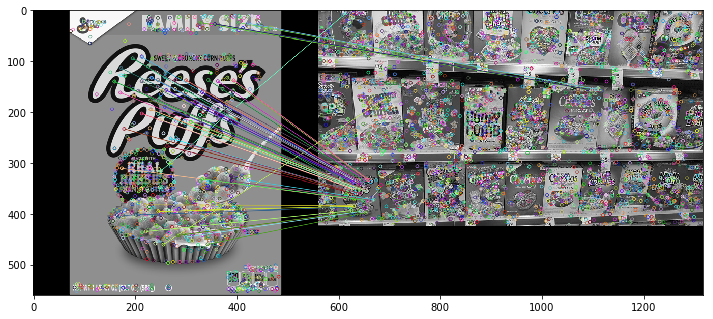

In [51]:
display(flann_matches)

With flags = 0, it is gonna show all the matches it found but only draw lines for the best ones here.

if we only want to see those lines we can set it to 2

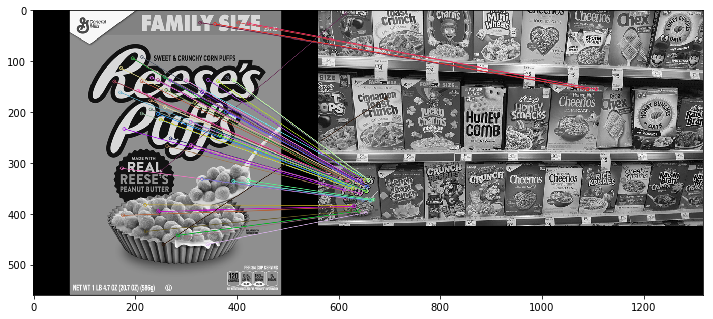

In [52]:
flann_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags = 2)
display(flann_matches)

# Now we can do something like add a mask to the image and show all the potential matches as red dots and the lines with green color

In [40]:
sift = cv2.xfeatures2d.SIFT_create()

In [41]:
kp1, des1 = sift.detectAndCompute(reeses, None)

kp2, des2 = sift.detectAndCompute(cereals, None)

In [43]:
# FLANN
# This is gonna be much faster than brute force methods but it does not find the best possible matches. Instead it is
# gonna the general good matches

# Now we can play around with flann parameter to increase the accuracy but that comes at the cost of time. It will slow down

# these are the default parameters and we can play around with them like increase the number of trees and all but it will
# it slower
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)

search_params = dict(checks=50)

In [44]:
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [53]:
matchesMask = [[0,0] for i in range(len(matches))]
matchesMask[:5]

[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]

In [54]:
# ratio test
# Now here we are not gonna append them in a good matches list but rather make changes to the mase wherever we find
# a good match

for i, (match1, match2) in enumerate(matches):
    if match1.distance < 0.7* match2.distance:
        matchesMask[i] = [1,0]

In [55]:
draw_params = dict(matchColor=(0,255,0),
                    singlePointColor=(255,0,0),
                   matchesMask = matchesMask,
                  flags = 0)

In [56]:
flann_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, matches, None, **draw_params)

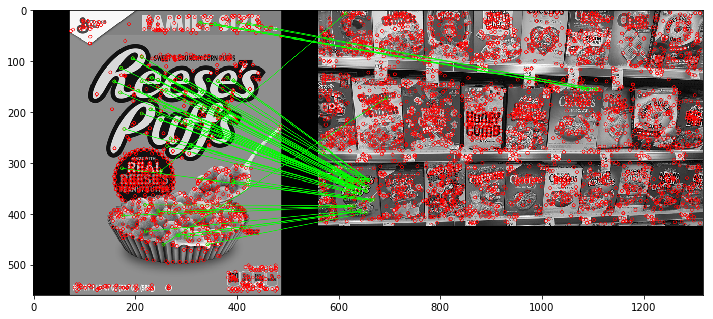

In [57]:
display(flann_matches)

Now the red dots are all the potential matches we have and the green lines are the best match out of all of them